# 一 简单实现
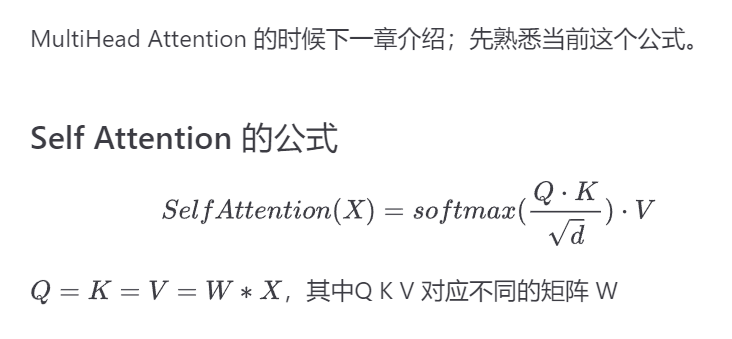

In [11]:
import math
import torch
import torch.nn as nn

class SelfAttentionV1(nn.Module):
    def __init__(self, hidden_dim: int = 768):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.value_proj = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, X):
        # X、Q、K、V:(batch,seq,hidden)
        Q = self.query_proj(X)
        K = self.key_proj(X)
        V = self.value_proj(X)

        # batch seq seq
        attention_value = torch.matmul(
            Q,K.permute(0,2,1)
        )/math.sqrt(self.hidden_dim)  
        # 除以一个根号d 防止做完乘积以后太大了 防止梯度消失（softmax边缘梯度小）。同时为了让 QK 的内积分布保持和输入一样
        # 这是因为点积的数量级增长很大，因此将 softmax 函数推向了梯度极小的区域
        attention_weight = torch.softmax(attention_value, dim = -1)
        print(attention_weight)
        # batch seq hidden
        return attention_weight@V



In [12]:
X=torch.rand(3,2,4)

net = SelfAttentionV1(4)
X

tensor([[[0.1483, 0.6623, 0.1418, 0.5586],
         [0.1880, 0.8153, 0.5906, 0.8997]],

        [[0.2485, 0.9110, 0.2282, 0.4349],
         [0.8862, 0.7489, 0.3763, 0.5996]],

        [[0.2048, 0.6381, 0.4581, 0.6355],
         [0.8906, 0.2688, 0.9419, 0.3917]]])

In [13]:
net(X)

tensor([[[0.5026, 0.4974],
         [0.5068, 0.4932]],

        [[0.4967, 0.5033],
         [0.4916, 0.5084]],

        [[0.5006, 0.4994],
         [0.5038, 0.4962]]], grad_fn=<SoftmaxBackward0>)


tensor([[[-0.5592, -0.3978, -0.3886, -0.8717],
         [-0.5582, -0.3982, -0.3875, -0.8704]],

        [[-0.2548, -0.3036, -0.3074, -0.8825],
         [-0.2539, -0.3025, -0.3079, -0.8834]],

        [[-0.4220, -0.0551, -0.4837, -0.9271],
         [-0.4227, -0.0567, -0.4833, -0.9267]]], grad_fn=<UnsafeViewBackward0>)

# 二 效率优化


In [18]:
class SelfAttentionV2(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.proj = nn.Linear(self.dim, self.dim*3)  # 可以是self.dim也可以是dim 这个函数里是一样的
        # 但是别的函数要用这里面的变量就得用self.dim 因为dim没有定义

    def forward(self, X):
        QKV = self.proj(X)
        Q,K,V = torch.split(QKV,self.dim,-1)
        att_weigth = torch.softmax(Q@K.permute(0,2,1)/math.sqrt(self.dim),-1)
        print(att_weigth)
        return att_weigth@ V

X= torch.rand(3,2,4)
net = SelfAttentionV2(4)

net(X)

tensor([[[0.4693, 0.5307],
         [0.4721, 0.5279]],

        [[0.5320, 0.4680],
         [0.5380, 0.4620]],

        [[0.5561, 0.4439],
         [0.5846, 0.4154]]], grad_fn=<SoftmaxBackward0>)


tensor([[[-0.2377,  0.3706,  0.0640, -0.6512],
         [-0.2385,  0.3696,  0.0633, -0.6510]],

        [[-0.2117,  0.1855,  0.0197, -0.5704],
         [-0.2110,  0.1834,  0.0191, -0.5694]],

        [[-0.1417,  0.3830, -0.0989, -0.7784],
         [-0.1380,  0.3742, -0.1067, -0.7788]]], grad_fn=<UnsafeViewBackward0>)

In [23]:
X.transpose(1,2) == X.transpose(2,1)


tensor([[[True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True]]])

# 三 加入细节

dropout

attention_mask

output矩阵映射

In [52]:
class SelfAttentionV3(nn.Module):
    def __init__(self, dim,dropout_rate=0.1):
        super().__init__()
        self.dim =dim
        self.proj = nn.Linear(dim,dim*3)
        self.attention_dropout= nn.Dropout(dropout_rate)

        self.output_proj = nn.Linear(dim,dim)

    def forward(self,X,attention_mask=None):
        QKV = self.proj(X)
        Q,K,V = QKV.split(self.dim,-1)

        attention_weight = Q @ K.transpose(-1,-2)/math.sqrt(self.dim)
        if attention_mask is not None:
            attention_weight = attention_weight.masked_fill(
                attention_mask == 0,  # 判断为真的会被替换为第二个参数
                -torch.inf
            )
        print("1", attention_weight)

        attention_weight = torch.softmax(
            attention_weight,
            dim = -1
        )
        print("2", attention_weight)
        attention_weight = self.attention_dropout(attention_weight)
        # 注意是对attention_weight dropout
        print("3", attention_weight)
        attention_result = attention_weight @ V

        output = self.output_proj(attention_result)
        return output


X =torch.rand(3,4,2)


# mark  batch seq seq
mark = torch.tensor(
    [
        [[1,1,1,0]],
        [[1,1,0,0]],
        [[1,0,0,0]]
    ]
)

mark.shape

torch.Size([3, 1, 4])

In [53]:
mark = mark.repeat(1,4,1) # 第0维重复1次 第1维重复4次 第2维重复1次
mark

tensor([[[1, 1, 1, 0],
         [1, 1, 1, 0],
         [1, 1, 1, 0],
         [1, 1, 1, 0]],

        [[1, 1, 0, 0],
         [1, 1, 0, 0],
         [1, 1, 0, 0],
         [1, 1, 0, 0]],

        [[1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0]]])

In [45]:
mark.shape

torch.Size([3, 4, 4])

In [46]:
X

tensor([[[0.5913, 0.4569],
         [0.3475, 0.5771],
         [0.1684, 0.4515],
         [0.2577, 0.1982]],

        [[0.9018, 0.4624],
         [0.7159, 0.9359],
         [0.5614, 0.6093],
         [0.3487, 0.4763]],

        [[0.4436, 0.5367],
         [0.2401, 0.8512],
         [0.1903, 0.0318],
         [0.5251, 0.2620]]])

In [54]:
net = SelfAttentionV3(2)

net(X)


1 tensor([[[-0.1979, -0.3578, -0.2308, -0.2308],
         [-0.4812, -0.7435, -0.5143, -0.4765],
         [-0.2718, -0.4729, -0.3102, -0.3045],
         [-0.2998, -0.5369, -0.3478, -0.3462]],

        [[-0.5154, -0.4347, -0.6024, -0.7007],
         [-0.3609, -0.2963, -0.4301, -0.4965],
         [-0.6783, -0.5810, -0.7834, -0.9155],
         [-0.7253, -0.6407, -0.8177, -0.9650]],

        [[-0.7961, -0.4469, -0.4519, -0.6656],
         [-0.3527, -0.1596, -0.2218, -0.3396],
         [-0.5977, -0.2843, -0.3681, -0.5595],
         [-0.8677, -0.4594, -0.5081, -0.7577]]], grad_fn=<DivBackward0>)
2 tensor([[[0.2640, 0.2250, 0.2555, 0.2555],
         [0.2673, 0.2056, 0.2586, 0.2685],
         [0.2668, 0.2182, 0.2568, 0.2582],
         [0.2705, 0.2134, 0.2578, 0.2583]],

        [[0.2610, 0.2829, 0.2392, 0.2168],
         [0.2582, 0.2754, 0.2409, 0.2255],
         [0.2638, 0.2907, 0.2375, 0.2081],
         [0.2641, 0.2874, 0.2408, 0.2078]],

        [[0.2013, 0.2854, 0.2840, 0.2293],
         [0

tensor([[[-0.3790, -0.1886],
         [-0.3090, -0.2181],
         [-0.3063, -0.2246],
         [-0.3814, -0.1902]],

        [[-0.3014, -0.1278],
         [-0.2938, -0.1939],
         [-0.2342, -0.1680],
         [-0.3030, -0.1290]],

        [[-0.2791, -0.1924],
         [-0.3612, -0.1640],
         [-0.3668, -0.1677],
         [-0.3716, -0.1702]]], grad_fn=<ViewBackward0>)

In [55]:
net(X,mark) # masked被弄出0  dropout也是随机弄0

1 tensor([[[-0.1979, -0.3578, -0.2308,    -inf],
         [-0.4812, -0.7435, -0.5143,    -inf],
         [-0.2718, -0.4729, -0.3102,    -inf],
         [-0.2998, -0.5369, -0.3478,    -inf]],

        [[-0.5154, -0.4347,    -inf,    -inf],
         [-0.3609, -0.2963,    -inf,    -inf],
         [-0.6783, -0.5810,    -inf,    -inf],
         [-0.7253, -0.6407,    -inf,    -inf]],

        [[-0.7961,    -inf,    -inf,    -inf],
         [-0.3527,    -inf,    -inf,    -inf],
         [-0.5977,    -inf,    -inf,    -inf],
         [-0.8677,    -inf,    -inf,    -inf]]], grad_fn=<MaskedFillBackward0>)
2 tensor([[[0.3546, 0.3022, 0.3431, 0.0000],
         [0.3654, 0.2811, 0.3535, 0.0000],
         [0.3597, 0.2942, 0.3462, 0.0000],
         [0.3647, 0.2877, 0.3476, 0.0000]],

        [[0.4798, 0.5202, 0.0000, 0.0000],
         [0.4839, 0.5161, 0.0000, 0.0000],
         [0.4757, 0.5243, 0.0000, 0.0000],
         [0.4788, 0.5212, 0.0000, 0.0000]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
    

tensor([[[-0.3587, -0.1830],
         [-0.3421, -0.2566],
         [-0.2725, -0.2304],
         [-0.3616, -0.1850]],

        [[-0.2392, -0.2492],
         [-0.3626, -0.1799],
         [-0.3630, -0.1804],
         [-0.2390, -0.2494]],

        [[-0.1512, -0.3410],
         [-0.1899, -0.0755],
         [-0.1899, -0.0755],
         [-0.1899, -0.0755]]], grad_fn=<ViewBackward0>)

In [24]:
3!=None


True

In [27]:
1e-20<100

True

In [26]:
3

3

In [31]:
-torch.inf>100

False